This notebook loads Yelp data related to Toronto restaurants only.  This will eventually replace the data model in the original data load module.

In [253]:
from neo4j.v1 import GraphDatabase, basic_auth
import csv
import json
import os
import pandas as pd
import matplotlib.pyplot as plt

data_dir = '/Users/gtenorio/neo4j_yelp_toronto/import/'

In [254]:
# Helper functions

# Specify CSV parameters through custom dialect
csv.register_dialect('custom', escapechar='\\', quotechar='"', quoting=csv.QUOTE_ALL)


def identity(x): 
    return x


def select(keys, d):
    return {key: value for (key, value) in d.items() if key in set(keys)}


# Converts the given value to a CSV formatted string
def toCSV(value):
    # Represent a list of items as a semicolon delimited string
    if type(value) == list:
        return ';'.join(value)

    # Surround fields with double quotes and handle escape characters
    if type(value) == str:
        return value.replace('"', '').replace('\\', '')

    return value


# Converts a dict to a list of CSV formatted strings, optionally restricting
# converted fields by passing in an ordered list of fields
def dictToCSV(obj, fields=None):
    fields = fields if fields is not None else obj.keys()
    return [toCSV(obj[k]) for k in fields]


# Takes a JSON file and writes it as a CSV file
def jsonToCSVFile(json_file, csv_file=None, transform=identity):

    root, ext = os.path.splitext(json_file)
    csv_file = csv_file if csv_file else root + '.csv'

    with open(json_file, 'r') as jsonFile, \
         open(csv_file, 'w') as csvFile:

        objs = transform(map(json.loads, jsonFile))
        first = next(objs)
        fields = first.keys()

        writer = csv.writer(csvFile, dialect='custom')
        writer.writerow(fields)         # write header

        writer.writerow(dictToCSV(first, fields))
        for obj in objs:
            writer.writerow(dictToCSV(obj, fields))

### Part 1: Convert Yelp JSON files to CSV format

#### A. Convert Business streaming JSON file to CSV

In [259]:
%%time

# only select businesses with at least 50 reviews
business_fields = ['business_id', 'name', 'categories', 'neighborhood', 'stars', 'review_count']
jsonToCSVFile(data_dir + "business.json",
              transform=lambda business: (select(business_fields, b) for b in business if b["city"] == 'Toronto' and 'Restaurants' in b['categories'] and b['review_count'] >= 50))


CPU times: user 3.99 s, sys: 90.9 ms, total: 4.08 s
Wall time: 4.1 s


#### b. Convert User streaming JSON file to CSV

In [262]:
%%time

# only select users who have written at least 25 reviews
user_fields = ['user_id','name','average_stars']
jsonToCSVFile(data_dir + "user.json", transform=lambda user: (select(user_fields, u) for u in user if u['review_count'] >= 25))

CPU times: user 36.5 s, sys: 1.79 s, total: 38.3 s
Wall time: 38.7 s


#### c. Convert Review streaming JSON file to CSV

In [263]:
%%time
review_fields = ['user_id', 'business_id', 'stars']
jsonToCSVFile(data_dir + "review.json", transform=lambda review: (select(review_fields, r) for r in review))

CPU times: user 2min 4s, sys: 4.47 s, total: 2min 9s
Wall time: 2min 10s


### Part 2: Load CSV files into Neo4j

In [264]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=basic_auth("neo4j", "neo4jneo4j"))

In [265]:
%%time

# Each time this notebook is run, we start with an empty graph database
with driver.session() as session:
    session.run("MATCH (n) DETACH DELETE n")

CPU times: user 5.78 ms, sys: 5.89 ms, total: 11.7 ms
Wall time: 78.5 ms


In [268]:
%%time

# Drop constraints from our database
with driver.session() as session:
    session.run("DROP CONSTRAINT ON (business:Business)   ASSERT business.id   IS UNIQUE")
    session.run("DROP CONSTRAINT ON (category:Category)   ASSERT category.name IS UNIQUE")
    session.run("DROP CONSTRAINT ON (user:User)           ASSERT user.id       IS UNIQUE")
    session.run("DROP CONSTRAINT ON (review:Review)       ASSERT review.id     IS UNIQUE")

CPU times: user 3.16 ms, sys: 2.97 ms, total: 6.13 ms
Wall time: 60.6 ms


In [269]:
%%time

# Create constraints in our database
with driver.session() as session:
    session.run("CREATE CONSTRAINT ON (business:Business)   ASSERT business.id   IS UNIQUE")
    session.run("CREATE CONSTRAINT ON (category:Category)   ASSERT category.name IS UNIQUE")
    session.run("CREATE CONSTRAINT ON (user:User)           ASSERT user.id       IS UNIQUE")
    session.run("CREATE CONSTRAINT ON (review:Review)       ASSERT review.id     IS UNIQUE")

CPU times: user 3.34 ms, sys: 2.49 ms, total: 5.83 ms
Wall time: 189 ms


#### A. Load Business data into Neo4j

In [270]:
%%time

load_business = """
    LOAD CSV WITH HEADERS FROM {input_dir} AS line                      
    WITH line 

    // Create Business nodes
    CREATE (business:Business {id: line.business_id})
    SET business.name         = line.name,
        business.neighborhood = line.neighborhood,
        business.avg_rating   = toFloat(line.stars)

    // Create Category nodes
    WITH line, business, split(line.categories, ";") as cat_list
    UNWIND cat_list as cat
    MERGE (category:Category {name: cat})
    CREATE (business)-[:IN_CATEGORY]->(category)
    """

with driver.session() as session:
    session.run(load_business, input_dir='file:///business.csv')

CPU times: user 2.03 ms, sys: 2.4 ms, total: 4.43 ms
Wall time: 1.26 s


In [271]:
%%time

# look at number of business in a category
query = """
        MATCH (c:Category)
        RETURN c.name, size(()-[:IN_CATEGORY]->(c)) AS num_business_in_cat   
        ORDER BY c, num_business_in_cat DESC
        """

with driver.session() as session:
    result = session.run(query)

result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df.sort_values('num_business_in_cat',ascending=False))

,c.name,num_business_in_cat
1,Restaurants,1707
2,Food,340
8,Nightlife,335
9,Bars,330
30,Canadian (New),232
25,Japanese,197
52,Breakfast & Brunch,188
32,Italian,159
5,Chinese,117
26,Sushi Bars,116


CPU times: user 43.2 ms, sys: 21.5 ms, total: 64.7 ms
Wall time: 84.1 ms


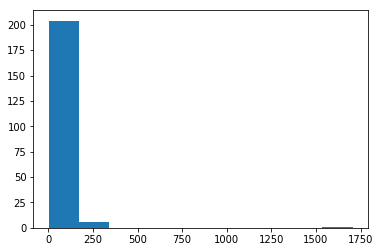

,num_business_in_cat
count,211.000000
mean,33.388626
std,126.715695
min,1.000000
0%,1.000000
25%,1.000000
50%,5.000000
75%,29.000000
80%,38.000000
85%,48.500000


In [272]:
# look at distribution of number of business per category
plt.hist(result_df['num_business_in_cat'])
plt.show()  

result_df.describe([0,0.25, 0.5,0.75,0.8,0.85,0.9,0.95,1])

In [275]:
%%time

# look at categories with less than 10 businesses
query = """
        MATCH (c:Category)
        WITH c.name AS cat, size(()-[:IN_CATEGORY]->(c)) AS num_business_in_cat  
        WHERE num_business_in_cat < 10
        RETURN cat, num_business_in_cat
        ORDER BY cat, num_business_in_cat DESC
        """

with driver.session() as session:
    result = session.run(query)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df.sort_values('num_business_in_cat',ascending=False))


,cat,num_business_in_cat
116,Turkish,9
33,Delis,9
97,Portuguese,9
18,Breweries,9
114,Taiwanese,8
94,Poke,8
11,Beer Bar,7
59,Himalayan/Nepalese,7
62,Hot Dogs,7
24,Chicken Shop,7


CPU times: user 23.2 ms, sys: 2.67 ms, total: 25.9 ms
Wall time: 41 ms


In [276]:
# get a list of categories with less than 10 businesses
categories_to_delete = result_df['cat'].tolist()
display(categories_to_delete)

['Accessories',
 'Active Life',
 'Afghan',
 'African',
 'Animal Shelters',
 'Arcades',
 'Argentine',
 'Arts & Crafts',
 'Australian',
 'Automotive',
 'Bagels',
 'Beer Bar',
 'Beer Hall',
 'Belgian',
 'Bistros',
 'Books',
 'Brasseries',
 'Brazilian',
 'Breweries',
 'Brewpubs',
 'Bubble Tea',
 'Cafeteria',
 'Cambodian',
 'Cheese Shops',
 'Chicken Shop',
 'Chocolatiers & Shops',
 'Coffee Roasteries',
 'Convenience Stores',
 'Cooking Classes',
 'Cuban',
 'Czech',
 'Dance Clubs',
 'Delicatessen',
 'Delis',
 'Department Stores',
 'Dinner Theater',
 'Do-It-Yourself Food',
 'Donairs',
 'Donuts',
 'Dry Cleaning & Laundry',
 'Egyptian',
 'Escape Games',
 'Ethical Grocery',
 'Falafel',
 'Farmers Market',
 'Fashion',
 'Festivals',
 'Filipino',
 'Fondue',
 'Food Court',
 'Food Stands',
 'Food Trucks',
 'Gas Stations',
 'Gay Bars',
 'Gelato',
 'German',
 'Grocery',
 'Hakka',
 'Health Markets',
 'Himalayan/Nepalese',
 'Hobby Shops',
 'Hookah Bars',
 'Hot Dogs',
 'Hot Pot',
 'Hotels',
 'Hotels & Trave

In [277]:
%%time

# Look at number of relationships that must be first removed, before removing the categories with less than 100 busineses
query = """
        MATCH (c:Category)<-[r:IN_CATEGORY]-()
        WHERE c.name in {category_list}
        RETURN COUNT(r)
        """

with driver.session() as session:
    result = session.run(query, category_list = categories_to_delete)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df)

,COUNT(r)
0,354


CPU times: user 8.23 ms, sys: 2.91 ms, total: 11.1 ms
Wall time: 37.7 ms


In [278]:
%%time

# Now actually delete relationships pointing into categories to delete 
query = """
        MATCH (c:Category)<-[r:IN_CATEGORY]-()
        WHERE c.name in {category_list}
        DELETE r
        """

with driver.session() as session:
    result = session.run(query, category_list = categories_to_delete)

CPU times: user 3.37 ms, sys: 2.38 ms, total: 5.75 ms
Wall time: 49.9 ms


In [279]:
%%time

# Now remove nodes corresponding to categories to be deleted
query = """
        MATCH (c:Category)
        WHERE c.name in {category_list}
        DELETE c
        """

with driver.session() as session:
    result = session.run(query, category_list = categories_to_delete)


CPU times: user 3.29 ms, sys: 2.66 ms, total: 5.94 ms
Wall time: 38.3 ms


In [280]:
%%time

# now let's look at the categories remaining and their business counts
query = """
        MATCH (c:Category)
        RETURN c.name, size(()-[:IN_CATEGORY]->(c)) AS num_business_in_cat   
        ORDER BY c, num_business_in_cat DESC
        """

with driver.session() as session:
    result = session.run(query)

result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df.sort_values('num_business_in_cat',ascending=False))

,c.name,num_business_in_cat
1,Restaurants,1707
2,Food,340
8,Nightlife,335
9,Bars,330
25,Canadian (New),232
20,Japanese,197
46,Breakfast & Brunch,188
27,Italian,159
5,Chinese,117
21,Sushi Bars,116


CPU times: user 22.9 ms, sys: 2.94 ms, total: 25.9 ms
Wall time: 28.9 ms


In [282]:
categories_to_delete_new = ['Restaurants','Food','Event Planning & Services','Lounges']

In [283]:
%%time
# need to remove categories: Restaurants, Food, Event Planning & Services, Lounges as they are irrelevant
# first need to remove relationships pointing to these nodes

query = """
        MATCH (c:Category)<-[r:IN_CATEGORY]-()
        WHERE c.name in {category_list}
        RETURN COUNT(r)
        """

with driver.session() as session:
    result = session.run(query, category_list = categories_to_delete_new)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df)

,COUNT(r)
0,2137


CPU times: user 9.39 ms, sys: 2.96 ms, total: 12.4 ms
Wall time: 17.4 ms


In [284]:
%%time
# remove relationships pointing to these nodes

query = """
        MATCH (c:Category)<-[r:IN_CATEGORY]-()
        WHERE c.name in {category_list}
        DELETE r
        """

with driver.session() as session:
    result = session.run(query, category_list=categories_to_delete_new)

CPU times: user 1.92 ms, sys: 2.26 ms, total: 4.18 ms
Wall time: 113 ms


In [285]:
%%time
# remove nodes

query = """
        MATCH (c:Category)
        WHERE c.name in {category_list}
        DELETE c
        """

with driver.session() as session:
    result = session.run(query, category_list=categories_to_delete_new)

CPU times: user 2.16 ms, sys: 2.37 ms, total: 4.53 ms
Wall time: 13.3 ms


In [286]:
%%time
# check number of category nodes we now have

query = """
        MATCH (c:Category)
        RETURN COUNT(c)
        """

with driver.session() as session:
    result = session.run(query)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df)

,COUNT(c)
0,81


CPU times: user 7.41 ms, sys: 2.71 ms, total: 10.1 ms
Wall time: 16 ms


In [287]:
%%time
# check number of business nodes we now have

query = """
        MATCH (b:Business)
        RETURN COUNT(b)
        """

with driver.session() as session:
    result = session.run(query)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df)

,COUNT(b)
0,1707


CPU times: user 7.45 ms, sys: 2.84 ms, total: 10.3 ms
Wall time: 14.4 ms


In [288]:
%%time
# check number of relationships between business and category nodes

query = """
        MATCH (b:Business)-[r:IN_CATEGORY]->(c:Category)
        RETURN COUNT(r)
        """

with driver.session() as session:
    result = session.run(query)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df)

,COUNT(r)
0,4554


CPU times: user 6.75 ms, sys: 2.78 ms, total: 9.53 ms
Wall time: 32.8 ms


#### b. Load Review data into Neo4j

In [289]:
%%time

# Note: We only want to load reviews associated with the businesses already in the graph (ie: restaurants in Toronto)
# with at least 50 reviews

load_review = """
    // Load and commit every 50000 records
    USING PERIODIC COMMIT 50000 
    LOAD CSV WITH HEADERS FROM {input_dir} AS line                      
    WITH line 

    // Only care about businesses that are already in the graph (ie: Toronto restaurants)
    MATCH (business:Business {id:line.business_id})
    MERGE (user:User         {id:line.user_id})
    
    CREATE (user)-[:REVIEWED  {stars:toInteger(line.stars)}]->(business)
    """

with driver.session() as session:
    session.run(load_review, input_dir='file:///review.csv')

CPU times: user 7.21 ms, sys: 5.89 ms, total: 13.1 ms
Wall time: 2min 38s


In [294]:
%%time
# get number of businesses

query = """
        MATCH (b:Business)
        RETURN COUNT(b)
        """

with driver.session() as session:
    result = session.run(query)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df)

,COUNT(b)
0,1707


CPU times: user 10.5 ms, sys: 3.06 ms, total: 13.6 ms
Wall time: 13.4 ms


In [295]:
%%time
# get number of users

query = """
        MATCH (u:User)
        RETURN COUNT(u)
        """

with driver.session() as session:
    result = session.run(query)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df)

,COUNT(u)
0,59563


CPU times: user 8.04 ms, sys: 2.79 ms, total: 10.8 ms
Wall time: 10.8 ms


In [296]:
%%time
# get number of reviews a business has received

query = """
        MATCH (u:User)-[r:REVIEWED]->(b:Business)
        RETURN b.name, COUNT(u) as num_reviews
        """

with driver.session() as session:
    result = session.run(query)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df.sort_values('num_reviews',ascending=False))

,b.name,num_reviews
893,Pai Northern Thai Kitchen,1494
646,Banh Mi Boys,1445
997,Khao San Road,1271
1500,KINKA IZAKAYA ORIGINAL,1184
665,KINTON RAMEN,993
1543,The Burger's Priest,970
1113,Terroni,946
152,Seven Lives Tacos Y Mariscos,945
221,La Carnita,879
472,Uncle Tetsu's Japanese Cheesecake,848


CPU times: user 67.4 ms, sys: 5.37 ms, total: 72.8 ms
Wall time: 790 ms


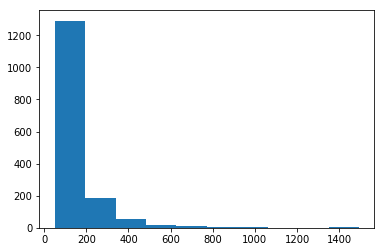

,num_reviews
count,1571.000000
mean,138.514322
std,132.489808
min,50.000000
0%,50.000000
25%,66.000000
50%,94.000000
75%,155.000000
80%,182.000000
85%,215.000000


In [297]:
# look at distribution of reviews
plt.hist(result_df['num_reviews'])
plt.show()  

result_df.describe([0,0.25, 0.5,0.75,0.8,0.85,0.9,0.95,1])

In [298]:
%%time
# get number of reviews a user has given

query = """
        MATCH (u:User)-[r:REVIEWED]->(b:Business)
        RETURN u.id, COUNT(r) as num_reviews
        """

with driver.session() as session:
    result = session.run(query)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df.sort_values('num_reviews',ascending=False))

,num_reviews,u.id
52148,463,CxDOIDnH8gp9KXzpBHJYXw
13757,281,TbhyP24zYZqZ2VJZgu1wrg
38314,273,0BBUmH7Krcax1RZgbH4fSA
44496,263,Q9mA60HnY87C1TW5kjAZ6Q
6698,249,FREeRQtjdJU83AFtdETBBw
3270,224,yT_QCcnq-QGipWWuzIpvtw
67,207,gwIqbXEXijQNgdESVc07hg
24777,203,V4TPbscN8JsFbEFiwOVBKw
43487,200,1fNQRju9gmoCEvbPQBSo7w
29660,197,8HCEPF0IflyB690Q745fKg


CPU times: user 1.17 s, sys: 95.6 ms, total: 1.27 s
Wall time: 2.47 s


In [300]:
%%time
# only want users who have reviewed at least 25 businesses

query = """
        MATCH (u:User)-[r:REVIEWED]->(b:Business)
        WITH u AS usr, COUNT(r) as num_reviews
        WHERE num_reviews >= 25
        RETURN usr.id, num_reviews
        """

with driver.session() as session:
    result = session.run(query)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df.sort_values('num_reviews',ascending=False))

,num_reviews,usr.id
440,463,CxDOIDnH8gp9KXzpBHJYXw
652,281,TbhyP24zYZqZ2VJZgu1wrg
751,273,0BBUmH7Krcax1RZgbH4fSA
119,263,Q9mA60HnY87C1TW5kjAZ6Q
560,249,FREeRQtjdJU83AFtdETBBw
1029,224,yT_QCcnq-QGipWWuzIpvtw
139,207,gwIqbXEXijQNgdESVc07hg
373,203,V4TPbscN8JsFbEFiwOVBKw
1200,200,1fNQRju9gmoCEvbPQBSo7w
1206,197,8HCEPF0IflyB690Q745fKg


CPU times: user 55 ms, sys: 3.52 ms, total: 58.5 ms
Wall time: 947 ms


In [306]:
%%time
# get actual list of users with less than 25 reviewed businesses

query = """
        MATCH (u:User)-[r:REVIEWED]->(b:Business)
        WITH u AS usr, COUNT(r) as num_reviews
        WHERE num_reviews < 25
        RETURN usr.id, num_reviews
        """

with driver.session() as session:
    result = session.run(query)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df.sort_values('num_reviews',ascending=False))

,num_reviews,usr.id
16110,24,CorMvaqZtz4O-Pr4QVSc3w
39470,24,Ahix-3uCOXmeaTUv0xF_zw
52857,24,5DcDiCJETu5EklCDdXtnLw
17801,24,1RKXN8HnIeelHjWDLJPr2Q
45191,24,QIRkA1xNLmzTlCOnq5zpWw
51659,24,a_adronfoaxpphBD5d_3Cw
27190,24,Dl5twqkJmR67cq9aZl2bIA
48985,24,vZEY5WEJ9sRxTGhm97132A
32445,24,Srv9jOGELiNGIJEqhS5_uQ
7497,24,os832o4NXDKxcTYEBN1Mmg


CPU times: user 1.08 s, sys: 14.5 ms, total: 1.09 s
Wall time: 1.86 s


In [312]:
users_to_delete = result_df['usr.id'].tolist()
display(users_to_delete)

['6cNWTJNL7RprQbINuk9Tow',
 'Vjj9e0DyU3TAkW1SfjGJwA',
 '9M5khi_ljVKNhjpSllGijA',
 'toJKjwWugNGGbDWDu7BHrA',
 'jdf15x7YE69Dd2a3o0hAag',
 'mEX7Th0ATtC2uHTjJZ-WpA',
 'H1Yv-VKsEa24oxjxdfqC1A',
 '6iNVJz9GVffaUpRhh-L5oA',
 'g-ay9De9XYMGhSLJVhfF6Q',
 'mz_sM_EF_UTVx7PlORZvmg',
 'zNV9mVGWBQTNuiHD3UE2OQ',
 'zHI19hN4-3vIJKoyg_ABcw',
 'qtUsaFx2AvVu_GNT0DZLLg',
 '9sv4lPr5owwLRzJPKkn6Vw',
 'l_4bL0IvJ_K7qkjt1S47mw',
 'nzdNGV8ymicZW86hjTna5Q',
 'nmdi96vbuPZ2mKNGLGEXTw',
 'uzK-HIiE07VVW34yrsxsmA',
 'ojNlFWR1J7RcYdovZpOC3w',
 'Jh8K6IdnntfpfqbO4LMDTQ',
 'JYaukmm7JV0w2SMfK10W-A',
 'eow60CLpmAjSIZ7t9ELy5Q',
 '440dqFMaKx4Ffy3kLtTn9g',
 'MMtGIFPuwFDUtkeU7ufp2w',
 '3vsho1SV3vfQo8SRvYKVJQ',
 'lNw5H1Skf-GeHlmQtU0u8Q',
 'yNrWluanydgnfwVaSsI7MQ',
 'HdBzWCcDVAa2mZ6G7GCtYw',
 'cDwqTkcDkxQVNuQmAx9AiA',
 'z5YnS1lNDvrB2KsySazEvg',
 'G8PWZ35a_99zzUtxQa3BlQ',
 'CqMF_iJAfFFjUouzER4eAA',
 'DoXmefosJBuTfEsq_PvPYw',
 '3Mils6AfdsCgUah7jmTd1Q',
 'lXy1rV7it7KftYPDIaKvhg',
 '9nDx6op7_W9QPRdD1vXN4A',
 'yQObvRp19eDaaLhOQoCCbA',
 

In [317]:
%%time
# remove relationships from users identified above

query = """
        MATCH (u:User)-[r:REVIEWED]->(b:Business)
        WHERE u.id in {user_list} 
        DELETE r
        """

with driver.session() as session:
    result = session.run(query, user_list=users_to_delete)


CPU times: user 363 ms, sys: 5.49 ms, total: 369 ms
Wall time: 9.2 s


In [325]:
%%time
# remove users identified above

query = """
        MATCH (u:User)
        WHERE u.id in {user_list} 
        DELETE u
        """

with driver.session() as session:
    result = session.run(query, user_list=users_to_delete)


CPU times: user 366 ms, sys: 5.42 ms, total: 371 ms
Wall time: 4.41 s


In [326]:
%%time
# remove relationships from users identified above

query = """
        MATCH (u:User)
        RETURN COUNT( u)
        """

with driver.session() as session:
    result = session.run(query)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df)

,COUNT( u)
0,1251


CPU times: user 7.91 ms, sys: 2.74 ms, total: 10.7 ms
Wall time: 17.3 ms


#### c. Load User data into Neo4j

In [327]:
%%time

# Note: We only care about setting properties for users who are already in the graph.

load_user = """
    USING PERIODIC COMMIT 50000 
    LOAD CSV WITH HEADERS FROM {input_dir} AS line                      
    WITH line 

    // Set properties on User nodes already in the graph
    MATCH (user:User {id: line.user_id})
    SET user.name              = line.name,
        user.avg_review_rating = toFloat(line.average_stars)
    """

with driver.session() as session:
    session.run(load_user, input_dir='file:///user.csv')

CPU times: user 2.58 ms, sys: 2.62 ms, total: 5.21 ms
Wall time: 13.3 s


In [328]:
%%time
# count nodes and relationships in the graph

query = """
        MATCH (u:User)
        RETURN COUNT( u)
        """

with driver.session() as session:
    result = session.run(query)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df)

,COUNT( u)
0,1251


CPU times: user 8.53 ms, sys: 3.76 ms, total: 12.3 ms
Wall time: 11.2 ms


In [329]:
%%time
# count nodes and relationships in the graph

query = """
        MATCH (b:Business)
        RETURN COUNT( b)
        """

with driver.session() as session:
    result = session.run(query)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df)

,COUNT( b)
0,1707


CPU times: user 7.55 ms, sys: 2.98 ms, total: 10.5 ms
Wall time: 17.3 ms


In [331]:
%%time
# count nodes and relationships in the graph

query = """
        MATCH ()-[r:IN_CATEGORY]->()
        RETURN COUNT(r)
        """

with driver.session() as session:
    result = session.run(query)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df)

,COUNT(r)
0,4554


CPU times: user 7.93 ms, sys: 2.88 ms, total: 10.8 ms
Wall time: 46.2 ms


In [332]:
%%time
# count nodes and relationships in the graph

query = """
        MATCH ()-[r:REVIEWED]->()
        RETURN COUNT(r)
        """

with driver.session() as session:
    result = session.run(query)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df)

,COUNT(r)
0,63141


CPU times: user 9.95 ms, sys: 3.17 ms, total: 13.1 ms
Wall time: 26.3 ms
